<a href="https://colab.research.google.com/github/PriyankaMath/CMPE258-Assignment3/blob/main/b)DeepNN_without_Pytorch_builtin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 layer Deep Neural Network for non linear Relu without using pytorch builtin layer functionality

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Prepare Data

In [ ]:
# 3 Dimension non-linear input data

n = 200
d = 3
x = torch.rand(n,d)
weights_true = torch.tensor([[2, 1,-1],[3,0,-1]]).T
bias_true = torch.tensor([[0.5],[0.1]])

y_true = torch.matmul((x ** 2).float() , weights_true.float()) + torch.matmul(x.float() , weights_true.float()) + bias_true.T.float()
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2, 1]), y: torch.Size([200, 2])


### Visualizing the data generated using TSNE

In [ ]:
from sklearn.manifold import TSNE
view = TSNE(n_components=2, n_jobs=5).fit_transform(x)
view.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(200, 2)

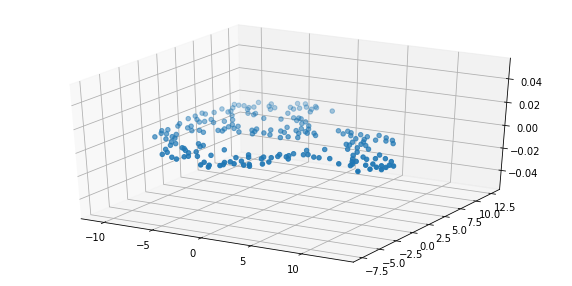

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#y_pred = y_pred.astype('int')
fig = plt.figure(figsize=(10,5))
tsne = fig.add_subplot(111, projection='3d')
tsne.scatter(*zip(*view))
plt.show()

In [ ]:
import math
import torch.nn as nn

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


## Linear layer
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.matmul(x, self.weights) + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = torch.matmul(self.x.T, gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = torch.matmul(gradient, self.weights.T)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient


## Adding non-linear activation function reLu
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


## Model class
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

##Calculating the loss 
loss = MSE()
model = TorchModel(d, 4)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(3.0868)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

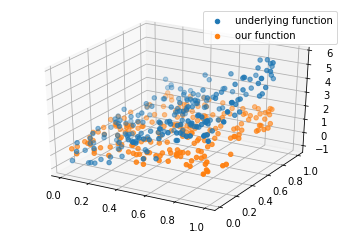

In [ ]:
plot_3d(x, y_true, model(x_tensor).detach())

In [ ]:
loss = MSE()
model = TorchModel(d, 10)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.01)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(2.6210)
tensor(2.4953)


In [ ]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.01, num_epochs=70)

Epoch 0, loss 2.4952950477600098
Epoch 1, loss 2.394974708557129
Epoch 2, loss 2.3152832984924316
Epoch 3, loss 2.2520134449005127
Epoch 4, loss 2.2015655040740967
Epoch 5, loss 2.1609561443328857
Epoch 6, loss 2.1277823448181152
Epoch 7, loss 2.1001548767089844
Epoch 8, loss 2.0766196250915527
Epoch 9, loss 2.0560758113861084
Epoch 10, loss 2.037703037261963
Epoch 11, loss 2.020897388458252
Epoch 12, loss 2.005218267440796
Epoch 13, loss 1.990347146987915
Epoch 14, loss 1.9760547876358032
Epoch 15, loss 1.9621765613555908
Epoch 16, loss 1.9485955238342285
Epoch 17, loss 1.935227632522583
Epoch 18, loss 1.9220134019851685
Epoch 19, loss 1.908909559249878
Epoch 20, loss 1.8958849906921387
Epoch 21, loss 1.8829176425933838
Epoch 22, loss 1.8699913024902344
Epoch 23, loss 1.8570934534072876
Epoch 24, loss 1.8442155122756958
Epoch 25, loss 1.8313500881195068
Epoch 26, loss 1.8184919357299805
Epoch 27, loss 1.8056368827819824
Epoch 28, loss 1.7927817106246948
Epoch 29, loss 1.77992308139801

In [ ]:
def tsne_plot(view, y, y_pred=None):
  fig = plt.figure()
  tsne = fig.add_subplot(111, projection='3d')
  tsne.scatter(view[:, 0], view[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    tsne.scatter(view[:, 0], view[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

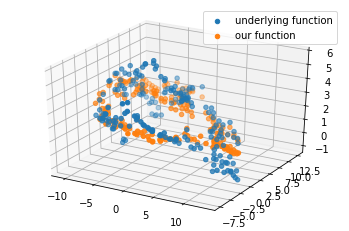

In [ ]:
tsne_plot(view, y_true, model(x_tensor).detach())

After Training the data is almost overlapping